In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [3]:
train_dataset  = train_datagen.flow_from_directory(directory = 'resized_train',
                                                   target_size = (100,100),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 67146 images belonging to 8 classes.


In [4]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'resized_train',
                                                  target_size = (100,100),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 16782 images belonging to 8 classes.


In [5]:
test_dataset = test_datagen.flow_from_directory(directory = 'resized_test',
                                                  target_size = (100,100),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 10931 images belonging to 8 classes.


In [6]:
base_model = tf.keras.applications.VGG16(input_shape=(100,100,3),include_top=False,weights="imagenet")

In [7]:
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [8]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(8,activation='softmax'))

In [9]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 3, 3, 512)         0         
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 batch_normalization (Batch  (None, 4608)              18432     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 32)                147488    
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                       

In [10]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [11]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [12]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('Vgg_model_new.h5')

es = EarlyStopping(verbose=1, patience=10)
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [13]:
history=model.fit(train_dataset,validation_data=valid_dataset ,epochs = 5,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/5
1050/1050 [==============================] - 1798s 2s/step - loss: 1.9689 - accuracy: 0.8744 - precision: 0.3356 - recall: 0.0051 - auc: 0.6510 - f1_score: 0.0100 - val_loss: 2.7963 - val_accuracy: 0.8590 - val_precision: 0.2246 - val_recall: 0.0523 - val_auc: 0.5784 - val_f1_score: 0.0840 - lr: 0.0010


C:\Users\rohan\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/5
1050/1050 [==============================] - 1784s 2s/step - loss: 1.8513 - accuracy: 0.8762 - precision: 0.5716 - recall: 0.0395 - auc: 0.7096 - f1_score: 0.0728 - val_loss: 2.1825 - val_accuracy: 0.8471 - val_precision: 0.3168 - val_recall: 0.1930 - val_auc: 0.6707 - val_f1_score: 0.2394 - lr: 0.0010
Epoch 3/5
1050/1050 [==============================] - 1812s 2s/step - loss: 1.7949 - accuracy: 0.8802 - precision: 0.6700 - recall: 0.0824 - auc: 0.7328 - f1_score: 0.1448 - val_loss: 1.7527 - val_accuracy: 0.8843 - val_precision: 0.8554 - val_recall: 0.0895 - val_auc: 0.7454 - val_f1_score: 0.1602 - lr: 0.0010
Epoch 4/5
1050/1050 [==============================] - 1835s 2s/step - loss: 1.7412 - accuracy: 0.8832 - precision: 0.6955 - recall: 0.1169 - auc: 0.7525 - f1_score: 0.1995 - val_loss: 1.8303 - val_accuracy: 0.8876 - val_precision: 0.8499 - val_recall: 0.1225 - val_auc: 0.7156 - val_f1_score: 0.2114 - lr: 0.0010
Epoch 5/5
1050/1050 [==============================] - 178

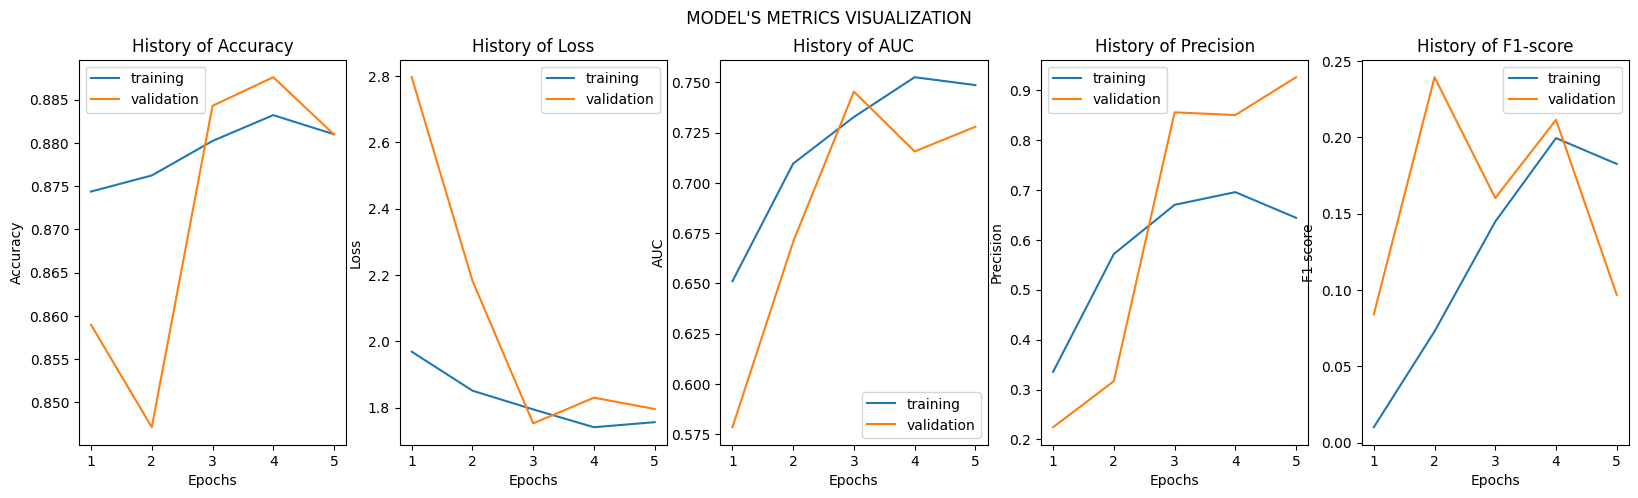

In [14]:

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

342/342 [==============================] - 155s 450ms/step
Test Accuracy: 33.98%
Confusion Matrix:
[[  34    0    0    0   73  105 1062  115]
 [   4    0    0    0   96   63  232   34]
 [  15    0    0    0   25   50  372   49]
 [  26    0    0    0   66  185  827  325]
 [   4    0    0    0 1384  115  701   75]
 [  29    0    0    0  104  202 1343  129]
 [  29    0    0    0   89  134 1414   85]
 [  37    0    0    0  103  180  336  680]]
Classification Report:
              precision    recall  f1-score   support

       angry       0.19      0.02      0.04      1389
    contempt       0.00      0.00      0.00       429
     disgust       0.00      0.00      0.00       511
        fear       0.00      0.00      0.00      1429
       happy       0.71      0.61      0.66      2279
     neutral       0.20      0.11      0.14      1807
         sad       0.22      0.81      0.35      1751
    surprise       0.46      0.51      0.48      1336

    accuracy                           0.34  

C:\Users\rohan\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rohan\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rohan\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

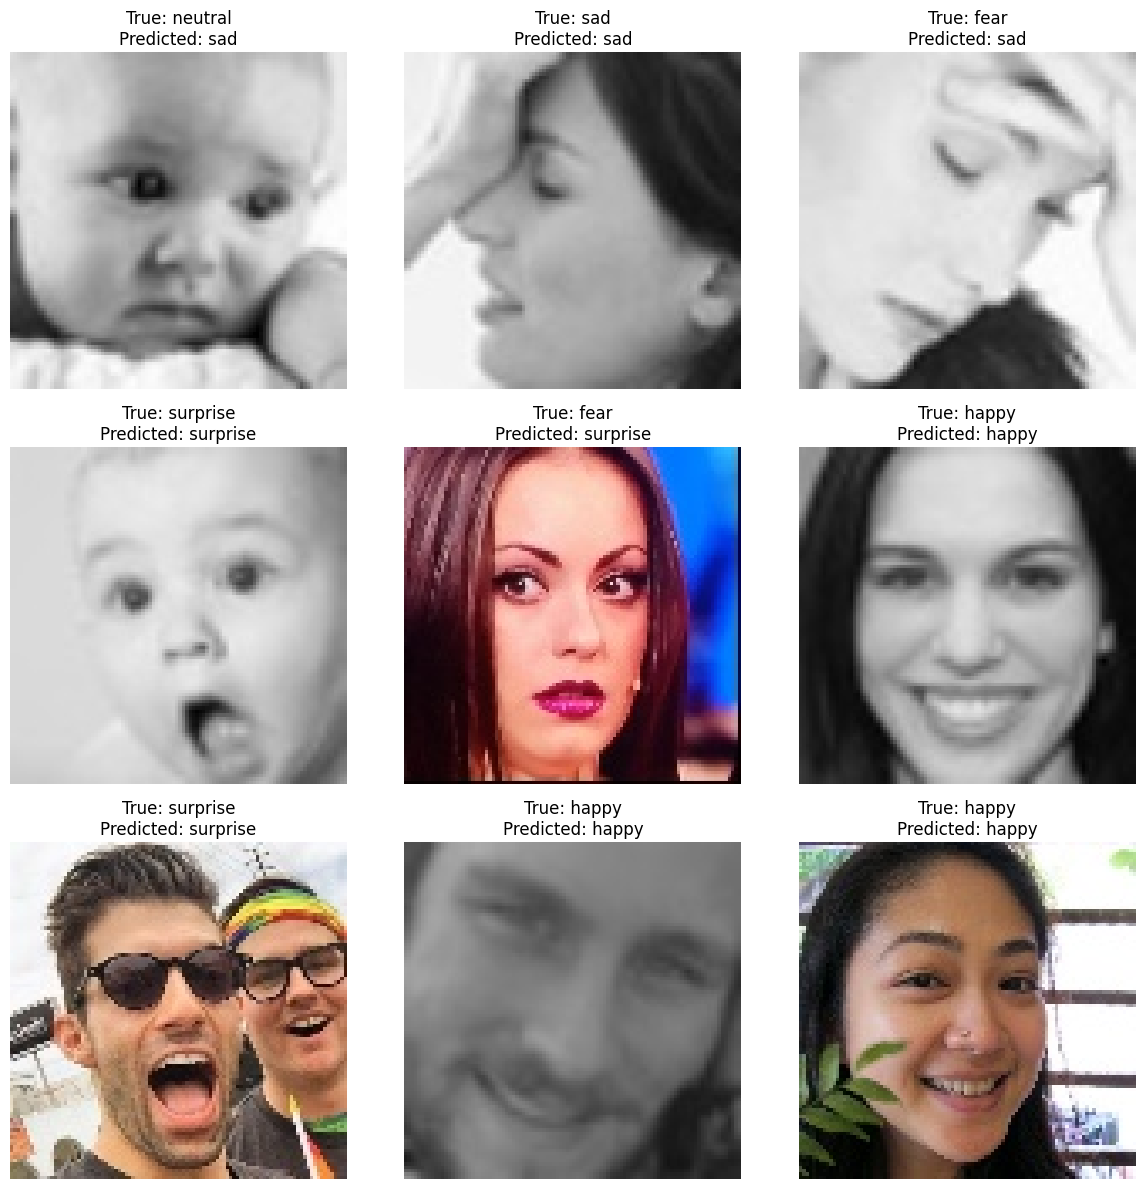

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define paths
test_dir = 'resized_test'
emotion_folders = os.listdir(test_dir)

# Data preparation
test_data = []
test_labels = []

for emotion in emotion_folders:
    folder_path = os.path.join(test_dir, emotion)
    for img in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img)
        image = plt.imread(img_path)
        image = np.resize(image, (100, 100, 3)) 
        test_data.append(image)
        test_labels.append(emotion)

# Convert lists to arrays
test_data = np.array(test_data)
test_labels = np.array(test_labels)

# Encode labels
label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(test_labels)

# Normalize data
test_data = test_data / 255.0

# Load the trained model
model = load_model('Vgg_model_new.h5', custom_objects={'f1_score': f1_score})

# Make predictions
predictions = model.predict(test_data)

# Convert predictions to label indices
predicted_labels = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(test_labels_encoded, predicted_labels)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Confusion matrix
conf_matrix = confusion_matrix(test_labels_encoded, predicted_labels)
print('Confusion Matrix:')
print(conf_matrix)

# Classification report
class_report = classification_report(test_labels_encoded, predicted_labels, target_names=label_encoder.classes_)
print('Classification Report:')
print(class_report)

# Display some predictions with images
import random

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for img, ax in zip(random.sample(range(len(test_data)), 9), axes):
    ax.imshow(test_data[img])
    true_label = label_encoder.inverse_transform([test_labels_encoded[img]])[0]
    predicted_label = label_encoder.inverse_transform([predicted_labels[img]])[0]
    ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}")
    ax.axis('off')

plt.tight_layout()
plt.show()
